# 02 - Data from the Web 
 By Kiran Bacsa, Samuel Beuret, and Valentine Santarelli


In [1]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd 
import numpy as np
import json 

import seaborn as sns
sns.set_palette('Blues')
sns.set_context("notebook")

import matplotlib.pyplot as plt
%matplotlib inline

import re

import warnings
warnings.filterwarnings('ignore')
from difflib import SequenceMatcher

##  200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). 

### Scrapping the web page 
Using Postman, part of the information needed was found  in a JSON file (name, rank, country, and region). The remaining information to scrap using Beautiful Soup was found on each university's page in the *div* of *class = faculty-main* . 
* number of faculty members international corresponds to the *div* of *class=inter faculty*
* number of faculty members total corresponds to the *div* of *class=total faculty*
* number of students international corresponds to the *div* of *class=total inter*
* number of students total corresponds to the *div* of *class=total student*

In [3]:

# get name, rank, country and region of the 200 first universities

#url found using Postman
url='https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508005996450'
universities= requests.get(url).json()['data'][0:200] #take the first 200 universities
#first part of the dataframe for topuniversities.com
df_qs1 = pd.DataFrame(universities)
df_qs1 = df_qs1.drop(['cc','core_id','guide', 'logo','score','stars','nid'], axis=1) #don't need this information

#list of urls to universities pages
urls =list(df_qs1['url'])

# function to get the rest of the needed information on each university page in a dictionnary
def get_details(url):
    university= requests.get('https://www.topuniversities.com' + url)
    soup= BeautifulSoup(university.text,'html.parser')
    data= soup.find_all('div', class_= 'faculty-main') 

    # number of faculty members international
    if(soup.find_all('div', class_ = 'inter faculty') != []):
        inter_fac_mem = float(soup.find_all('div', class_ = 'inter faculty')[0].find_all('div', class_ = 'number')[0].string.replace(',',''))
    else:
        inter_fac_mem = float('nan')
        
    # number of faculty members total
    if(soup.find_all('div', class_ = 'total faculty')!= []):
        total_fac_mem = float(soup.find_all('div', class_ = 'total faculty')[0].find_all('div', class_ = 'number')[0].string.replace(',',''))
    else:
        total_fac_mem = float('nan')
        
    # number of students international
    if(soup.find_all('div', class_ = 'total inter')!= []):
        inter_student = float(soup.find_all('div', class_ = 'total inter')[0].find_all('div', class_ = 'number')[0].string.replace(',',''))
    else:
        inter_student = float('nan')
        
    # number of students total
    if(soup.find_all('div', class_ = 'total student')!= []):
        total_student = float(soup.find_all('div', class_ = 'total student')[0].find_all('div', class_ = 'number')[0].string.replace(',',''))
    else:
        total_student = float('nan')

    #output dictionnary (keep the url to merge later)
    details = {'url' : url, '(QS) #faculty members international' : inter_fac_mem,
          '(QS) #faculty members total' : total_fac_mem,
          '(QS) #students international': inter_student,
          '(QS) #students total' : total_student}
    return details

#list of dictionnaries 
details = []    
for url in urls:
    details.append(get_details(url))
#convert to pd.DataFrame
df_qs2 = pd.DataFrame(details)

#merge the two dataframes using the url
df_qs= pd.merge(df_qs1, df_qs2, 'outer')
df_qs.rename(columns={'rank_display': '(QS) rank', 'title': 'name'}, inplace=True)
df_qs = df_qs.drop('url', axis=1) #drop the url once the merge is done

df_qs.head()


,country,(QS) rank,region,name,(QS) #faculty members international,(QS) #faculty members total,(QS) #students international,(QS) #students total
0,United States,1,North America,Massachusetts Institute of Technology (MIT),1679.0,2982.0,3717.0,11067.0
1,United States,2,North America,Stanford University,2042.0,4285.0,3611.0,15878.0
2,United States,3,North America,Harvard University,1311.0,4350.0,5266.0,22429.0
3,United States,4,North America,California Institute of Technology (Caltech),350.0,953.0,647.0,2255.0
4,United Kingdom,5,Europe,University of Cambridge,2278.0,5490.0,6699.0,18770.0


In order to avoid scrapping the web pages every time we need the dataset *df_qs*, the later was exported in a file using the pandas fucntion *to_pickle()*, and imported with *from_pickle()*.

In [4]:
#USE PICKLE TO SAVE DF
filename="./data/QS_ranking"
df_qs.to_pickle(filename)

In [5]:
#USE PICKLE TO LOAD DF
filename="./data/QS_ranking"
df_qs =pd.read_pickle(filename)
df_qs.head()

,country,(QS) rank,region,name,(QS) #faculty members international,(QS) #faculty members total,(QS) #students international,(QS) #students total
0,United States,1,North America,Massachusetts Institute of Technology (MIT),1679.0,2982.0,3717.0,11067.0
1,United States,2,North America,Stanford University,2042.0,4285.0,3611.0,15878.0
2,United States,3,North America,Harvard University,1311.0,4350.0,5266.0,22429.0
3,United States,4,North America,California Institute of Technology (Caltech),350.0,953.0,647.0,2255.0
4,United Kingdom,5,Europe,University of Cambridge,2278.0,5490.0,6699.0,18770.0


We verify that there is no ties in the ranking and if so, we keep the order of display on the web page.
We found the ties using the *duplicated()* pandas function. Each time a duplicate is found (i.e a tie) we increment all the ranks below by one.
As expected the rank column is unique at the end.

In [6]:
df_qs['(QS) rank']=df_qs['(QS) rank'].str.extract('(\d+)').astype('int64')
bool_dup = df_qs['(QS) rank'].duplicated()
ind_dup = bool_dup[bool_dup == True].index

#until no more duplicates
for ind in ind_dup :
    #add +1 the all the ranks below this duplicate
    df_qs['(QS) rank'][ind : len(df_qs['(QS) rank'])] = df_qs['(QS) rank'][ind : len(df_qs['(QS) rank']) ] + 1;

#verify the rank column is unique i.e no ties   
print(df_qs['(QS) rank'].is_unique)



True


### Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?

In [7]:
# adding the ratios to the df_qs dataframe
df_qs['(QS) faculty members/students'] = df_qs['(QS) #faculty members total']/df_qs['(QS) #students total']
df_qs['(QS) international students/ total students'] = df_qs['(QS) #students international']/df_qs['(QS) #students total']
df_qs.head()

,country,(QS) rank,region,name,(QS) #faculty members international,(QS) #faculty members total,(QS) #students international,(QS) #students total,(QS) faculty members/students,(QS) international students/ total students
0,United States,1,North America,Massachusetts Institute of Technology (MIT),1679.0,2982.0,3717.0,11067.0,0.269450,0.335863
1,United States,2,North America,Stanford University,2042.0,4285.0,3611.0,15878.0,0.269870,0.227422
2,United States,3,North America,Harvard University,1311.0,4350.0,5266.0,22429.0,0.193945,0.234785
3,United States,4,North America,California Institute of Technology (Caltech),350.0,953.0,647.0,2255.0,0.422616,0.286918
4,United Kingdom,5,Europe,University of Cambridge,2278.0,5490.0,6699.0,18770.0,0.292488,0.356899


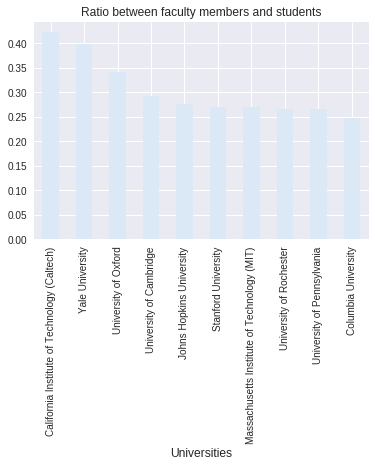

In [8]:
#Plotting the ratio faculty members/students for the 10 first universities
df_ratio1 = df_qs.sort_values('(QS) faculty members/students', ascending =False) #sort by ratio
df_ratio1.set_index(['name'],inplace=True) #set name of universities as index for the plot
df_ratio1= df_ratio1['(QS) faculty members/students'] #extract only the column  needed

ax = df_ratio1[0:10].plot.bar()
ax.set_xlabel("Universities", fontsize=12)
plt.title("Ratio between faculty members and students")
plt.show()


The best universities in term of ratio of faculty members and students are :
* Caltech
* Yale University
* University of Oxford

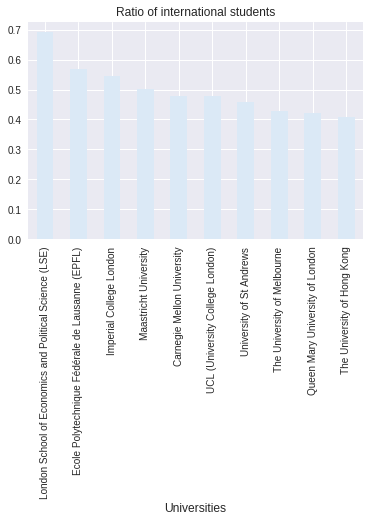

In [9]:
#Plotting the ratio of international students for the first 10 universities
df_ratio2 = df_qs.sort_values('(QS) international students/ total students', ascending =False)#sort by ratio
df_ratio2.set_index(['name'],inplace=True) #set name of universities as index for the plot
df_ratio2= df_ratio2['(QS) international students/ total students']#extract only the column  needed

ax = df_ratio2[0:10].plot.bar()
ax.set_xlabel("Universities", fontsize=12)
plt.title("Ratio of international students")
plt.show()

The best universities in term of ratio of international students are :
* LSE
* EPFL
* Imperial College London



### Which are the best country in term of: (a) ratio between faculty members and students, (b) ratio of international students?

In [10]:
#Create a new dataframe by aggregating values by country.
df_country = df_qs.groupby('country').mean()
df_country.head()

,(QS) rank,(QS) #faculty members international,(QS) #faculty members total,(QS) #students international,(QS) #students total,(QS) faculty members/students,(QS) international students/ total students
country,,,,,,,
Argentina,84.000000,3165.000000,16421.000000,27109.000000,122301.000000,0.134267,0.221658
Australia,82.555556,1264.666667,2448.222222,11817.666667,33554.888889,0.076407,0.346878
Austria,203.000000,786.000000,2058.500000,9833.500000,31723.000000,0.057298,0.306095
Belgium,157.500000,546.750000,2011.500000,4253.250000,28766.750000,0.092131,0.160108
Brazil,181.500000,194.000000,3775.000000,1526.000000,46141.500000,0.079505,0.034050


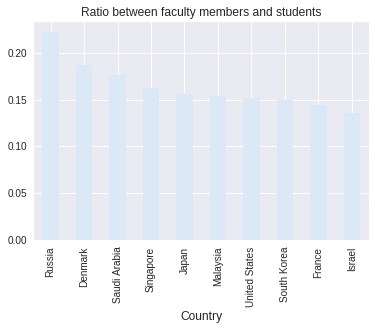

In [11]:
#sort by ratio and extract the columns needed
df_country_ratio1 = df_country.sort_values('(QS) faculty members/students', ascending =False)
df_country_ratio1= df_country_ratio1['(QS) faculty members/students']

#Plot the sorted countries
ax = df_country_ratio1[0:10].plot.bar()
ax.set_xlabel("Country", fontsize=12)
plt.title("Ratio between faculty members and students")
plt.show()

The best countries in term of ratio of faculty members and students are :
* Russia
* Denmark
* Saudi Arabia

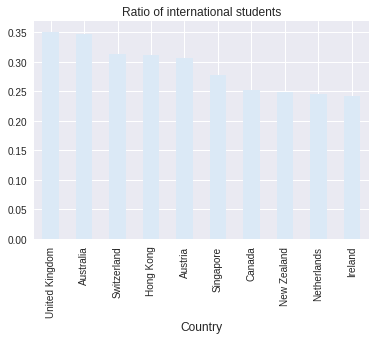

In [12]:
#sort by ratio and extract the columns needed
df_country_ratio2 = df_country.sort_values('(QS) international students/ total students', ascending =False)
df_country_ratio2= df_country_ratio2['(QS) international students/ total students']

#Plot the sorted countries
ax = df_country_ratio2[0:10].plot.bar()
ax.set_xlabel("Country", fontsize=12)
plt.title("Ratio of international students")
plt.show()

The best countries in term of ratio of international students are :
* UK
* Australia
* Switzerland

### Which are the best region in term of: (a) ratio between faculty members and students, (b) ratio of international students?

In [13]:
#Create a new dataframe by aggregating values by region.
df_region = df_qs.groupby('region').mean()
df_region.head()

,(QS) rank,(QS) #faculty members international,(QS) #faculty members total,(QS) #students international,(QS) #students total,(QS) faculty members/students,(QS) international students/ total students
region,,,,,,,
Africa,232.000000,379.000000,1733.000000,3325.000000,19593.000000,0.088450,0.169703
Asia,103.684211,688.162162,2808.789474,2897.368421,21236.921053,0.134673,0.132394
Europe,135.719101,759.528090,2453.460674,5049.033708,21991.584270,0.120003,0.245932
Latin America,177.714286,806.857143,6483.142857,5267.285714,62250.000000,0.096779,0.071751
North America,95.000000,827.094340,3436.283019,5511.622642,29176.471698,0.144831,0.202437


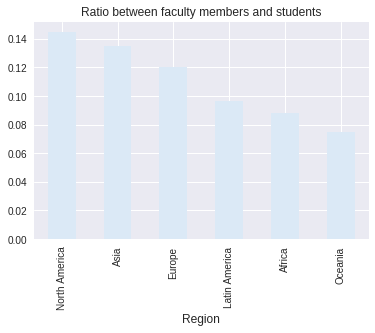

In [14]:
#Sort by ratio and extract the columns needed
df_region_ratio1 = df_region.sort_values('(QS) faculty members/students', ascending =False)
df_region_ratio1= df_region_ratio1['(QS) faculty members/students']

#Plot the sorted regions
ax = df_region_ratio1.plot.bar()
ax.set_xlabel("Region", fontsize=12)
plt.title("Ratio between faculty members and students")
plt.show()

The best regions in term of ratio of faculty members and students are :
* North America
* Asia
* Europe

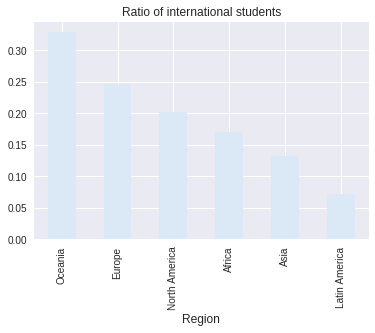

In [15]:
df_region_ratio2 = df_region.sort_values('(QS) international students/ total students', ascending =False)
df_region_ratio2= df_region_ratio2['(QS) international students/ total students']

ax = df_region_ratio2.plot.bar()
ax.set_xlabel("Region", fontsize=12)
plt.title("Ratio of international students")
plt.show()

The best regions in term of ratio of international students are :
* Oceania
* Europe
* North America

##  200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)).

### Scrapping the web page 

On the page of the 2018 Times Higher Eduction ranking, we have found a direct link to a JSON page (given by the URL in the code below). This allowed us to directly load the JSON dataset with the tools provided by pandas, without using Requests or BeautifulSoup.

We performed a preprocessing by selecting only the first 200 ranks of the dataset, removing the "equal" symbols in front of the rank numbers, renaming the columns and removing the commas in the numbers.

Since international student and staff ratios are given, we need to multiply them with the overall number of students to get the total staff and international students count. The number of international staff is however not available in the dataset, nor the region of the university. 

We also added a command to save the dataset in a file to avoid loading the data from internet at every execution.

In [16]:

url='https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

json_dict= requests.get(url).json()
raw_data = pd.DataFrame(json_dict['data'])
raw_data.columns
df_times=raw_data[['name','rank','location','stats_number_students','stats_pc_intl_students','stats_student_staff_ratio']]

df_times['rank']=df_times['rank'].str.extract('(\d+)').astype('int64')
df_times = df_times.loc[df_times['rank']<201]
df_times.rename(columns={'location':'country','stats_number_students':'students','stats_pc_intl_students':'international students','stats_student_staff_ratio':'staff'},inplace=True)

df_times['students'] = df_times['students'].str.replace(',','').astype('int64')

df_times['international students'] = df_times['international students'].str.extract('(\d+)').astype('float64')
df_times['international students'] = (df_times['international students']/100)*df_times['students'].astype('float64')
df_times['international students'] = df_times['international students'].astype('int64')

df_times['staff'] = df_times['staff'].astype('float64')
df_times['staff'] = df_times['students'].astype('float64')/df_times['staff']
df_times['staff'] = df_times['staff'].astype('int64')

df_times.rename(columns={'rank': '(Times) rank', 'title': 'name','staff':'(Times) #faculty members total', 'students':'(Times) #students total','international students':'(Times) #students international' }, inplace=True)
df_times.head()

,name,(Times) rank,country,(Times) #students total,(Times) #students international,(Times) #faculty members total
0,University of Oxford,1,United Kingdom,20409,7755,1822
1,University of Cambridge,2,United Kingdom,18389,6436,1687
2,California Institute of Technology,3,United States,2209,596,339
3,Stanford University,3,United States,15845,3485,2112
4,Massachusetts Institute of Technology,5,United States,11177,3800,1284


In [17]:
#USE PICKLE TO SAVE DF
filename="./data/Times_ranking"
df_times.to_pickle(filename)

In [18]:
#USE PICKLE TO LOAD DF
filename="./data/Times_ranking"
df_times =pd.read_pickle(filename)
df_times.head()

,name,(Times) rank,country,(Times) #students total,(Times) #students international,(Times) #faculty members total
0,University of Oxford,1,United Kingdom,20409,7755,1822
1,University of Cambridge,2,United Kingdom,18389,6436,1687
2,California Institute of Technology,3,United States,2209,596,339
3,Stanford University,3,United States,15845,3485,2112
4,Massachusetts Institute of Technology,5,United States,11177,3800,1284


Similarly to the QS dataset, we removed the duplicated rank in the list, and verified that they are unique.

In [20]:
bool_dup = df_times['(Times) rank'].duplicated()
ind_dup = bool_dup[bool_dup == True].index

#until no more duplicates
for ind in ind_dup :
    #add +1 the all the ranks below this duplicate
    df_times['(Times) rank'][ind : len(df_times['(Times) rank'])] = df_times['(Times) rank'][ind : len(df_times['(Times) rank']) ] + 1;
    
print(df_times['(Times) rank'].is_unique)

True


### Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?

We displayed the ratios between the faculty members and students for the 10 first universities.

In [22]:
df_times['(Times) faculty members/students']=df_times['(Times) #faculty members total'].astype('float64')/df_times['(Times) #students total']
df_times['(Times) international students/ total students']=df_times['(Times) #students international'].astype('float64')/df_times['(Times) #students total']

df_plot=df_times[['name','(Times) faculty members/students','(Times) international students/ total students']]
df_plot.set_index(['name'],inplace=True) #set name of universities as index for the plot

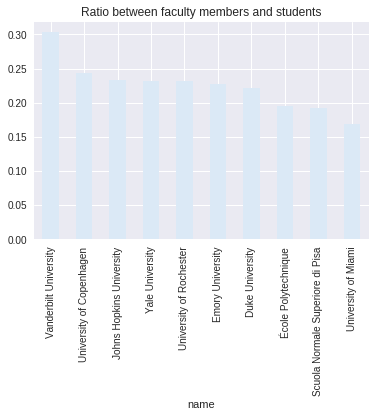

In [23]:
df_plot.sort_values('(Times) faculty members/students',ascending=False)['(Times) faculty members/students'].head(10).plot(kind='bar', title='Ratio between faculty members and students')

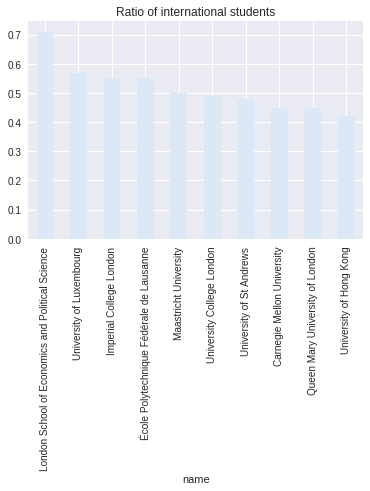

In [24]:
df_plot.sort_values('(Times) international students/ total students',ascending=False)['(Times) international students/ total students'].head(10).plot(kind='bar', title='Ratio of international students')

According to the Times ranking, we can see that the three best universities concerning the staff ratio :
* Vanderbuilt University
* University of Copenhagen
* Johns Hopkins University

Similarly, the best universities concerning the international students ratio are
* London School of Economics and Polotical Science
* University of Luxembourg
* Imperial College London

We can see that it is different from the universities obtained with the QS ranking.

### Which are the best country in term of: (a) ratio between faculty members and students, (b) ratio of international students?

We averaged the staff and international students ratios for every country present in the Times ranking and display them in a plot.

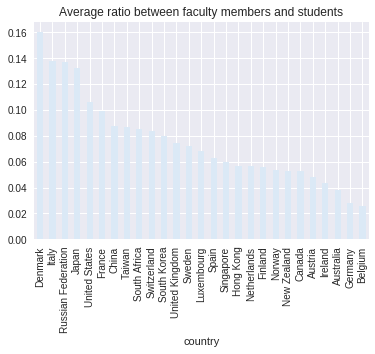

In [25]:
df_times.groupby(['country'])['(Times) faculty members/students'].mean().sort_values(ascending=False).plot(kind='bar',title='Average ratio between faculty members and students')

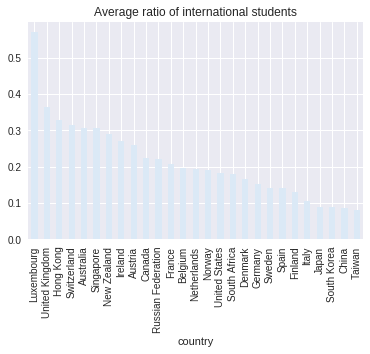

In [26]:
df_times.groupby(['country'])['(Times) international students/ total students'].mean().sort_values(ascending=False).plot(kind='bar',title='Average ratio of international students')

The three coutries were the staff ratio is the highest are:
* Denmark
* Italy
* Russian Federation

The countries were the international students ratio is the highest are:
* Luxemburg
* United Kingdom
* Hong Kong

In the same way than with the universities, the results are not completely coherents with the QS ranking, even if more or less the same countries are on the top of both lists.

### Which are the best region in term of: (a) ratio between faculty members and students, (b) ratio of international students?

Since the region of each university are not given in the original dataset, we needed to manually define them by sorting the different countries. We averaged the ratios and displayed them, and we also displayed the total number of universities per region, to have a comparisson basis.

In [27]:
region = {'Asia':['China','Hong Kong','Japan','Singapore','South Korea','Taiwan']
          ,'Europe':['Austria','Belgium','Denmark','Finland','France','Germany','Ireland','Italy','Luxembourg','Netherlands','Norway','Russian Federation','Spain','Sweden','Switzerland','United Kingdom']
          ,'North America':['Canada','United States']
          ,'Africa':['South Africa']
          ,'Oceania':['Australia','New Zealand']}

region = { f : i for i in region for f in region[i] }

df_times['region'] = df_times['country'].map(region)

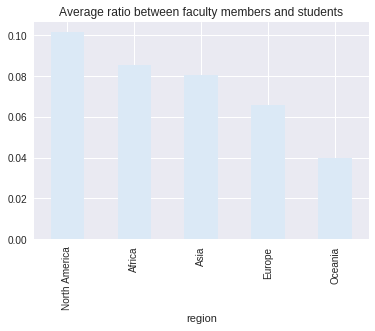

In [28]:
df_times.groupby(['region'])['(Times) faculty members/students'].mean().sort_values(ascending=False).plot(kind='bar',title='Average ratio between faculty members and students')

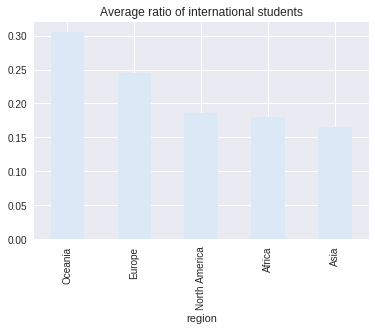

In [29]:
df_times.groupby(['region'])['(Times) international students/ total students'].mean().sort_values(ascending=False).plot(kind='bar',title='Average ratio of international students')

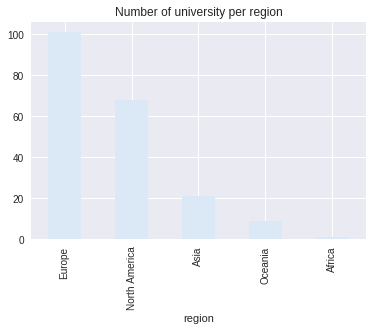

In [30]:
df_times.groupby(['region'])['(Times) rank'].count().sort_values(ascending=False).plot(kind='bar',title='Number of university per region')

The three regions where the staff ratios are the highest are:
* North America
* Africa
* Asia

The three regions where the international student ratios are the highest are:
* Oceania
* Europe
* North America

We can see that the results are coherent with the ones given by the QS ranking. One important difference is the Africa's average staff ratio, but it can be due to the uncertainty due to the only one relevant university in Africa.


## Merging of the two DataFrames using university names. 
Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

One of the main problems that was observed was the fact that the Times ranking uses the universties' names expressed in their native language unlike the Qs-Ranking which uses the English name. The first step was therefore to clean our data by translating certain key words and caracters to their English equivalents. A specific translation was made for LMU Munich because its name in the QS-ranking was too distinct from its Times counterpart to be matched. Furthermore, redundant stop words that do not carry any relevant information such as 'The' and 'Of' were removed in order to make the university names more distinct.

In [31]:
replace_target = ["É","é","&","Ludwig-Maximilians-Universität","-","Universite","Universität","Universitaet","Universitat","Technische","Autònoma","München"]
replace_with = ["E","e","and","LMU"," ","University","University","University","University","Technical","Autonomous","Munich"]
remove = ["The ","the ","Of ","of "]

for i in range(len(replace_target)):
    df_qs['name'] = df_qs['name'].str.replace(replace_target[i], replace_with[i])
    df_times['name'] = df_times['name'].str.replace(replace_target[i], replace_with[i])

for word in remove:
    df_qs['name'] = df_qs['name'].str.replace(word, "")
    df_times['name'] = df_times['name'].str.replace(word, "")


We can then define the functions that will be used to match the university names between each other. The first step in each function groups the universities by country. This operation considerably reduces the number of possible false positives during the matching phase. During this matching phase, for each country, we compare the similarity of the universities between themselves. If this similarity is above a predefined threshold, both universities are considered to be a match and their indexes are paired together. These universities are then removed from the symmetric difference datasets. The first function uses the SequenceMatcher similarity. This similarity is defined as 2.0\*M/T, where T is the total number of elements in both sequences, and M is the number of matches. The second function defines the similarity as the sum of the ratios of the number of common words versus the length of the universities' names (this function was mainly defined in order to compare similar names with different word orders). Both these functions return the dataframes containing the universities that haven't been paired up as well as the list of the paired up indexes.

In [32]:
# match universities according to name similarity
def find_common_unmerged(df_qs_out, df_times_out, threshold):
    n_duplicates = 0
    matched_top = []
    matched_time = []
    
    top_grouped = df_qs_out.groupby('country')
    time_grouped = df_times_out.groupby('country')

    countries = pd.Series(list(set(df_qs_out['country']).intersection(set(df_times_out['country']))))
    
    for country in countries:        
        unis_top = top_grouped.get_group(name=country)
        unis_time = time_grouped.get_group(name=country)     
        for name in unis_top['name']:
            for compare in unis_time['name']:
                score = SequenceMatcher(None, name, compare).ratio()
                if score > threshold:
                    n_duplicates = n_duplicates + 1
                    print('Matched ', name, ' with ', compare, ' with score ',score)
                    matched_top.extend(df_qs_out.index[df_qs_out['name'] == name])
                    matched_time.extend(df_times_out.index[df_times_out['name'] == compare])
                    
    print('Number of duplicates found : ', n_duplicates, 'out of ', len(df_qs_out['name']), ' unmerged universities.')
    df_qs_out = df_qs_out.drop(matched_top, axis=0)
    df_times_out = df_times_out.drop(matched_time, axis=0)
    return df_qs_out, df_times_out, matched_top, matched_time

In [33]:
# match universities according to common substring
def find_common_unmerged_by_substrings(df_qs_out, df_times_out, threshold):
    n_duplicates = 0
    matched_top = []
    matched_time = []
    
    top_grouped = df_qs_out.groupby('country')
    time_grouped = df_times_out.groupby('country')

    countries = pd.Series(list(set(df_qs_out['country']).intersection(set(df_times_out['country']))))
    
    for country in countries:        
        unis_top = top_grouped.get_group(name=country)
        unis_time = time_grouped.get_group(name=country)     
        for name in unis_top['name']:
            for compare in unis_time['name']:
                top_name_words = name.split()
                time_name_words = compare.split()
                common = set(top_name_words).intersection( set(time_name_words) )
                score = len(common)/len(top_name_words) + len(common)/len(time_name_words)
                if score > threshold:
                    n_duplicates = n_duplicates + 1
                    print('Matched ', name, ' with ', compare, ' with score ',score)
                    matched_top.extend(df_qs_out.index[df_qs_out['name'] == name])
                    matched_time.extend(df_times_out.index[df_times_out['name'] == compare])
                    
    print('Number of duplicates found : ', n_duplicates, 'out of ', len(df_qs_out['name']), ' unmerged universities.')
    df_qs_out = df_qs_out.drop(matched_top, axis=0)
    df_times_out = df_times_out.drop(matched_time, axis=0)
    return df_qs_out, df_times_out, matched_top, matched_time


We can now run these functions with different thresholds on the subdataframes that contain the symmetric differences of both datasets with respect to names.

In [34]:
# get universities that weren't merged
df_qs_out = df_qs[~df_qs['name'].isin(df_times['name'])]
df_times_out = df_times[~df_times['name'].isin(df_qs['name'])]

total_matched_top = []
total_matched_time = []
m_top = []
m_time = []

# threshold : 0.9
df_qs_out, df_times_out, m_top, m_time = find_common_unmerged(df_qs_out, df_times_out, 0.9)
total_matched_top.extend(m_top)
total_matched_time.extend(m_time)
del m_top[:]
del m_time[:]

# threshold : 0.85
df_qs_out, df_times_out, m_top, m_time = find_common_unmerged(df_qs_out, df_times_out, 0.85)
total_matched_top.extend(m_top)
total_matched_time.extend(m_time)
del m_top[:]
del m_time[:]

# by substrings
df_qs_out, df_times_out, m_top, m_time = find_common_unmerged_by_substrings(df_qs_out, df_times_out, 1.4)
total_matched_top.extend(m_top)
total_matched_time.extend(m_time)
del m_top[:]
del m_time[:]


Matched  KIT, Karlsruhe Institute Technology  with  Karlsruhe Institute Technology  with score  0.9230769230769231
Matched  Humboldt University zu Berlin  with  Humboldt University Berlin  with score  0.9454545454545454
Matched  Freie University Berlin  with  Free University Berlin  with score  0.9777777777777777
Matched  Nanyang Technological University, Singapore (NTU)  with  Nanyang Technological University, Singapore  with score  0.9347826086956522
Matched  National University Singapore (NUS)  with  National University Singapore  with score  0.90625
Matched  ETH Zurich   Swiss Federal Institute Technology  with  ETH Zurich – Swiss Federal Institute Technology Zurich  with score  0.9108910891089109
Matched  Ecole Polytechnique Federale de Lausanne (EPFL)  with  Ecole Polytechnique Federale de Lausanne  with score  0.9195402298850575
Matched  Massachusetts Institute Technology (MIT)  with  Massachusetts Institute Technology  with score  0.918918918918919
Matched  University Californi

Now that we have detected the university pairs, we can change the Times ranking names to their QS ranking equivalents and merge both datasets.

In [35]:
# replace time names with their top equivalent : 
for i in range(len(total_matched_time)):
    df_times.loc[total_matched_time[i],'name'] = df_qs.loc[total_matched_top[i],'name']


In [36]:
df_merged = pd.merge(df_qs, df_times, how='outer')
df_merged.head()

,country,(QS) rank,region,name,(QS) #faculty members international,(QS) #faculty members total,(QS) #students international,(QS) #students total,(QS) faculty members/students,(QS) international students/ total students,(Times) rank,(Times) #students total,(Times) #students international,(Times) #faculty members total,(Times) faculty members/students,(Times) international students/ total students
0,United States,1.0,North America,Massachusetts Institute Technology (MIT),1679.0,2982.0,3717.0,11067.0,0.269450,0.335863,6.0,11177.0,3800.0,1284.0,0.114879,0.339984
1,United States,2.0,North America,Stanford University,2042.0,4285.0,3611.0,15878.0,0.269870,0.227422,4.0,15845.0,3485.0,2112.0,0.133291,0.219943
2,United States,3.0,North America,Harvard University,1311.0,4350.0,5266.0,22429.0,0.193945,0.234785,7.0,20326.0,5284.0,2283.0,0.112319,0.259963
3,United States,4.0,North America,California Institute Technology (Caltech),350.0,953.0,647.0,2255.0,0.422616,0.286918,3.0,2209.0,596.0,339.0,0.153463,0.269805
4,United Kingdom,5.0,Europe,University Cambridge,2278.0,5490.0,6699.0,18770.0,0.292488,0.356899,2.0,18389.0,6436.0,1687.0,0.091740,0.349992


## Exploratory analysis
* Find useful insights in the data by performing an exploratory analysis. 



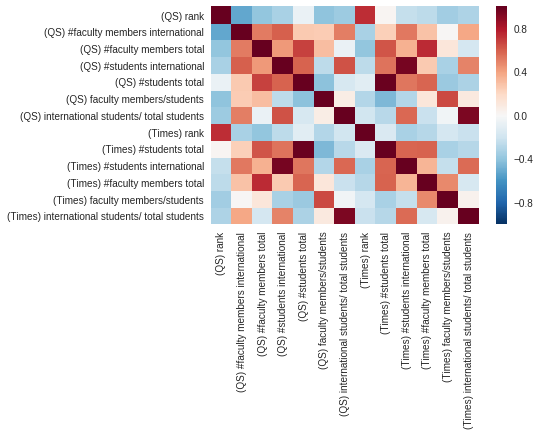

In [37]:
import seaborn as sns
df_merged = pd.merge(df_qs, df_times, how='outer')

corr_spearman= df_merged.corr(method='spearman')
sns.heatmap(corr_spearman)

As shown above we started by plotting the correlation matrix using the Spearman method which is more appropriate for ranking variables not knowing if it's a linear dependence between the variables. Also, using the Spearman method we do not need to make any assumptions on the distribution of the data (cf.([Statistics solutions](http://www.statisticssolutions.com/correlation-pearson-kendall-spearman/)).
Let's look at specific parts of this matrix:

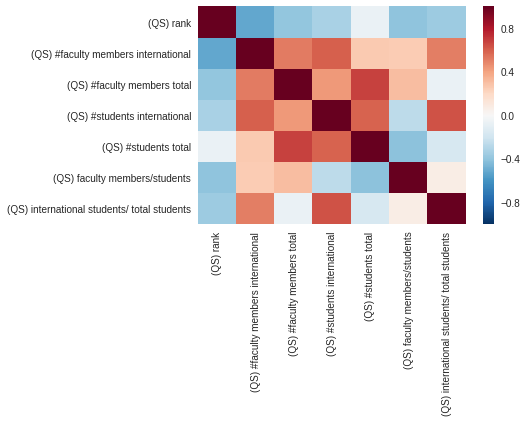

In [38]:
corr_spearman.index
corr_qs_qs=corr_spearman[['(QS) rank', '(QS) #faculty members international',
       '(QS) #faculty members total', '(QS) #students international',
       '(QS) #students total', '(QS) faculty members/students',
       '(QS) international students/ total students']].loc[
        :'(QS) international students/ total students'];
sns.heatmap(corr_qs_qs)

The matrix shown above is the correlation matrix of the variables imported or implemented from the [QS ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018). Passing the fact that the variables are correlated with themselves, several other expected strong correlations are noticed between:
* the number of **total faculty** members and **total students**: this can be explained as the number of professors grows with the number of students;
* the number of **international students** and the ratio **international students/students** (as one is used to compute the other);
* the number of **international faculty** members and the number of **international students**: this correlation is interesting. We can suppose that the international dimension of a university attracts both international students and professors.
* the number of **total students** members and the number of **international students** (as one is part of the other);
* the number of **international faculty** members and **total faculty** members (as one is part of the other) and
* the number of **international faculty** members and the ratio **international students/students**. 


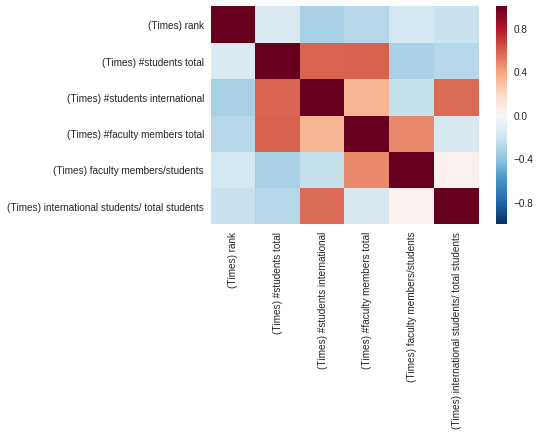

In [39]:
corr_times_times=corr_spearman[['(Times) rank','(Times) #students total', '(Times) #students international',
       '(Times) #faculty members total', '(Times) faculty members/students',
       '(Times) international students/ total students']].loc['(Times) rank':];
sns.heatmap(corr_times_times)

The matrix shown above is the correlation matrix of the variables imported or implemented from the [Times ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking). Passing the fact that the variables are correlated with themselves, several other expected strong correlation  are noticed between:
* the number of **total students** members and the number of **international students** (as one is part of the other);
* the number of **total faculty** members and **total students**(explainde before);
* the number of **international students** and the ratio **international students/students** (as one is used to compute the other)

Compare to the QS ranking, we found a stronger correlation between:
* the number of  **total faculty** members and and the ratio **faculty members/students** (as one is used to compute the other)


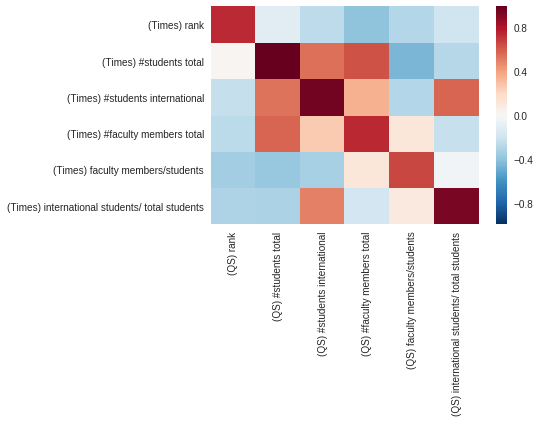

In [40]:
corr_qs_times=corr_spearman[['(QS) rank','(QS) #students total','(QS) #students international',
                              '(QS) #faculty members total',
                            '(QS) faculty members/students',
                               '(QS) international students/ total students']].loc['(Times) rank':];
sns.heatmap(corr_qs_times)

The matrix shown above is the correlation matrix of the variables imported or implemented from both the QS and Times ranking 2018 web pages. 

First, we can noticed that corresponding variables in both web sites are not perfectly correlated. This is expected for the rank, as the QS and Times migth not use the same algorithm. Althougth for other variables, a difference between two values is interesting. We can notice that the following variables have different values in both ranking:
* the total number of students : correlation between QS and Times = 0.9897;
* the number of international students: correlation = 0.9549;
* the total number of faculty members: surprisingly low correlation = 0.7437;

Both web sites don't have the same data which they're basing their ranking on. The notion of faculty members migth be differently interpreted in both rankings which could explain the low correlation.

The matrix shows some "quasi-diagonality" and so several other expected strong correlation are noticed between:
* the number of **total students** members and the number of **international students** (as one is part of the other);
* the number of **total faculty** members and **total students**:(explained before);
* the number of **international students** and the ratio **international students/students** (as one is used to compute the other);


# Defining the best university

* Can you find the best university taking in consideration both rankings? Explain your approach.

To determine the best university, we decided to use a Condorcet method (for futher informations: https://en.wikipedia.org/wiki/Condorcet_method) since it has interesting properties. Its basic principle is to elect a winner that beats every other concurrent (here, the universities) in a referundum at the majority of the voters (here, the rankings).

We group the univeristies two by two and we perform a vote (each university has a vote from one of the ranking if its score is higher than the other one). The overall score of the university is the number of vote it wins.

It has a drawback since many of the univerities are tied in ranking. So we tried to counter this effect by also considering the Shanghai ranking. Both results are shown below, firstly without the Shanghai ranking, and secondly with it.

In [41]:
#Parsing the dataset of the Shanghai ranking

#basic url
universities= requests.get('http://www.shanghairanking.com/ARWU2017.html')
soup= BeautifulSoup(universities.text,'html.parser')

#find table encapsulatin the wanted information
html_shanghai= soup.find_all('table', id="UniversityRanking")
#recover the interesting rows (twice for even and odd rows)
rank_shanghai_even= html_shanghai[0].find_all('tr', class_="bgfd")
rank_shanghai_odd= html_shanghai[0].find_all('tr', class_="bgf5")

#list of dictionnaries, one per university
uni_list=[]

# for each even rows 
for uni in rank_shanghai_even[0:50]:
    #recover: rank, name and url to uni'spage
    uni_rank=int(uni.find('td').text);
    uni_name=uni.find('a').text
    uni_url='http://www.shanghairanking.com/' + uni.find('a')['href']; 
    #from ulr recover country and region
    uni_request= requests.get(uni_url)
    uni_soup= BeautifulSoup(uni_request.text,'html.parser')
    uni_country= uni_soup.find('div', class_="tab_content").find_all('td')[5].text
    uni_region= uni_soup.find('div', class_="tab_content").find_all('td')[3].text
    #append as dictionnary in the list
    uni_list.append({'name' : uni_name, 'rank Shanghai' : uni_rank,
          'country' : uni_country,
          'region': uni_region})

#same for odd rows   
for uni in rank_shanghai_odd[0:50]:
    uni_rank=int(uni.find('td').text);
    uni_name=uni.find('a').text
    uni_url='http://www.shanghairanking.com/' + uni.find('a')['href']; 
    uni_request= requests.get(uni_url)
    uni_soup= BeautifulSoup(uni_request.text,'html.parser')
    uni_country= uni_soup.find('div', class_="tab_content").find_all('td')[5].text
    uni_region= uni_soup.find('div', class_="tab_content").find_all('td')[3].text
    uni_list.append({'name' : uni_name, 'rank Shanghai' : uni_rank,
          'country' : uni_country,
          'region': uni_region})
    
#convert list of dictionnary as dataframe
df_shanghai=pd.DataFrame(uni_list)
#sort rank as we had to do  for even and odd rows separatly
df_shanghai=df_shanghai.sort_values('rank Shanghai', ascending=True)

df_shanghai.set_index('rank Shanghai')

df_shanghai.head()

,country,name,rank Shanghai,region
0,USA,Harvard University,1,Northern America
50,USA,Stanford University,2,Northern America
1,UK,University of Cambridge,3,Northern Europe
51,USA,Massachusetts Institute of Technology (MIT),4,Northern America
2,USA,"University of California, Berkeley",5,Northern America


In [42]:
print(df_shanghai.index.is_unique)

True


In [43]:
#USE PICKLE TO SAVE DF (explained before)
filename="./data/Shanghai_ranking"
df_shanghai.to_pickle(filename)

In [44]:
#USE PICKLE TO LOAD DF (explained before)
filename="./data/Shanghai_ranking"
df_shanghai =pd.read_pickle(filename)
df_shanghai.head()

,country,name,rank Shanghai,region
0,USA,Harvard University,1,Northern America
50,USA,Stanford University,2,Northern America
1,UK,University of Cambridge,3,Northern Europe
51,USA,Massachusetts Institute of Technology (MIT),4,Northern America
2,USA,"University of California, Berkeley",5,Northern America


Here we merge the Shanghai dataset with the overall dataset obtained above. It is exactly the same principle with firstly removing and replacing some specific words, then finding common words and strings with also considering the country. There is however an additional step since we need to replace some country name with the one given in the merged dataset.

In [45]:



country_target=['USA','UK']
country_with=['United States','United Kingdom']

for i in range(len(country_target)):
    df_shanghai['country'] = df_shanghai['country'].str.replace(country_target[i], country_with[i])

for i in range(len(replace_target)):
    df_shanghai['name'] = df_shanghai['name'].str.replace(replace_target[i], replace_with[i])

for word in remove:
    df_shanghai['name'] = df_shanghai['name'].str.replace(word, "")
    
df_shanghai_out = df_shanghai[~df_shanghai['name'].isin(df_merged['name'])]
df_merged_out = df_merged[~df_merged['name'].isin(df_shanghai['name'])]

total_matched_merged = []
total_matched_shanghai = []
m_merged = []
m_shanghai = []

# threshold : 0.9
df_merged_out, df_shanghai_out, m_merged, m_shanghai = find_common_unmerged(df_merged_out, df_shanghai_out, 0.9)
total_matched_merged.extend(m_merged)
total_matched_shanghai.extend(m_shanghai)
del m_merged[:]
del m_shanghai[:]

# threshold : 0.85
df_merged_out, df_shanghai_out, m_merged, m_shanghai = find_common_unmerged(df_merged_out, df_shanghai_out, 0.85)
total_matched_merged.extend(m_merged)
total_matched_shanghai.extend(m_shanghai)
del m_merged[:]
del m_time[:]

# by substrings
df_merged_out, df_shanghai_out, m_merged, m_shanghai = find_common_unmerged_by_substrings(df_merged_out, df_shanghai_out, 1.49)
total_matched_merged.extend(m_merged)
total_matched_shanghai.extend(m_shanghai)
del m_merged[:]
del m_shanghai[:]

for i in range(len(total_matched_shanghai)):
    df_shanghai.loc[total_matched_shanghai[i],'name'] = df_merged.loc[total_matched_merged[i],'name']

df_shanghai=df_shanghai[['name','rank Shanghai']]
    
df_rank = pd.merge(df_merged, df_shanghai, how='outer')
df_rank=df_rank[['name','(Times) rank','(QS) rank','rank Shanghai']]
df_rank.columns=['name','TI rank','QS rank','SH rank']

Matched  University Göttingen  with  University Goettingen  with score  0.926829268292683
Matched  National University Singapore (NUS)  with  National University Singapore  with score  0.90625
Matched  University California, Berkeley (UCB)  with  University California, Berkeley  with score  0.9117647058823529
Matched  University California, Los Angeles (UCLA)  with  University California, Los Angeles  with score  0.9066666666666666
Matched  University California, San Diego (UCSD)  with  University California, San Diego  with score  0.9014084507042254
Matched  University Wisconsin Madison  with  University Wisconsin   Madison  with score  0.9655172413793104
Matched  University North Carolina, Chapel Hill  with  University North Carolina at Chapel Hill  with score  0.9487179487179487
Matched  University California, Santa Barbara (UCSB)  with  University California, Santa Barbara  with score  0.9113924050632911
Matched  University Colorado Boulder  with  University Colorado at Boulder  wi

Here we create a function to compare the rank of each pair of university, outputing 1 if the first is higher, or 0.

In [46]:

def compute_vote(rank_serie):
    rank_array = np.array(rank_serie)
    rank_array[np.isnan(rank_array)]=201
    rank_mat=np.tile(rank_array,(len(rank_array),1))
    rank_cmp=np.less_equal(rank_mat,np.transpose(rank_mat)).astype(int)
    return rank_cmp

In [47]:
TI_cmp=compute_vote(df_rank['TI rank'])
SH_cmp=compute_vote(df_rank['SH rank'])
QS_cmp=compute_vote(df_rank['QS rank'])

The vote is then performed.

In [48]:
tot_mat=np.greater(QS_cmp+TI_cmp,1).astype(int)
df_rank['cond_score']= tot_mat.sum(axis=0)
df_rank.sort_values(['cond_score'],ascending=False).head(10)

,name,TI rank,QS rank,SH rank,cond_score
0,Massachusetts Institute Technology (MIT),6.0,1.0,4.0,249
1,Stanford University,4.0,2.0,2.0,249
2,Harvard University,7.0,3.0,1.0,248
4,University Cambridge,2.0,5.0,3.0,248
5,University Oxford,1.0,6.0,7.0,248
3,California Institute Technology (Caltech),3.0,4.0,9.0,248
7,Imperial College London,9.0,8.0,27.0,245
8,University Chicago,10.0,9.0,10.0,244
9,ETH Zurich Swiss Federal Institute Technology,11.0,10.0,24.0,243
12,Princeton University,8.0,13.0,6.0,241


We can see here the results of the Condorcet method considering only the Times and QS rankings. We can see that we didn't get a unique best university (Stanford and MIT). We can also notice that the four next have the exact same score, and they can't be differentiated. We can also see that the total ranking is very similar to the QS one, and much less than the Times's one.

In [49]:
tot_mat=np.greater(QS_cmp+TI_cmp+SH_cmp,1.5).astype(int)
df_rank['cond_score']= tot_mat.sum(axis=0)
df_rank.sort_values(['cond_score'],ascending=False).head(10)

,name,TI rank,QS rank,SH rank,cond_score
1,Stanford University,4.0,2.0,2.0,253
4,University Cambridge,2.0,5.0,3.0,251
0,Massachusetts Institute Technology (MIT),6.0,1.0,4.0,251
2,Harvard University,7.0,3.0,1.0,251
5,University Oxford,1.0,6.0,7.0,249
3,California Institute Technology (Caltech),3.0,4.0,9.0,248
12,Princeton University,8.0,13.0,6.0,247
7,Imperial College London,9.0,8.0,27.0,245
8,University Chicago,10.0,9.0,10.0,245
15,Yale University,14.0,16.0,11.0,243


We can see that adding the Shanghai ranking does not change one of the best university (Stanford) but there are now three universities that share the second rank. We can also see that there is another conflict between the eigth and ninth university, so there is a slightly significant improvement in terms of conflicts. Adding the Shanghai ranking also lowered the ranked of some universities (such as ETH or Imperial College) which have a poor rank in the Shanghai ranking.

We can however say that the world best university according to the three rankings is Stanford.